### Datos Personales
- Nombre: Diego Santiago Solorzano Arancibia
- Carrera: Ing. en Ciencias de la Computación
- Enlace Git: https://github.com/DiegoSolorzano9/Inteligencia-Artificial-I-2-2024/tree/9983cd96a5dd346074fb704785e2e562952a6ca2/Primer%20Parcial
- Enlace del Dataset: https://www.kaggle.com/datasets/fedesoriano/cifar10-python-in-csv?select=train.csvTemática

In [ ]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

import pandas as pd

# Libreria para graficos
from matplotlib import pyplot

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import dask.dataframe as dd
from sklearn.metrics import accuracy_score

### 1. Se modificó el dataset original

Se duplicó el número de ejemplos de 50.000 a 100.000 ejemplos. También se adicionaron 3 nuevas columnas que son:

- category_char (Columna 3074): Indica si la imagen pertenece a un "vehículo" (V), un "animal" (A), o un "objeto volador" (F).
- category_text (Columna 3075): Proporciona una descripción textual de la clase de cada imagen. Por ejemplo, "avión", "automóvil", etc.
- category_bool (Columna 3076): Indica si la imagen pertenece a un "vehículo" (True) o a un "animal" (False).

In [3]:
# Configuración
# tamaño de la imagen 32 * 32 px * 3 canales de color (RGB)
input_layer_size = 3072
# número de clases
num_labels = 10

# Cargar el dataset original
data = pd.read_csv('train.csv')

# Cargando a X todas las filas y todas las columnas menos la última
X = data.iloc[:, :-1].values
# Cargando a y todas las filas y solo la última columna
y = data.iloc[:, -1].values

# Un diccionario que mapea cada etiqueta numérica (0 a 9)
class_names = {
    0: ('F', 'avión', True),
    1: ('V', 'automóvil', True),
    2: ('F', 'pájaro', False),
    3: ('A', 'gato', False),
    4: ('A', 'ciervo', False),
    5: ('A', 'perro', False),
    6: ('A', 'rana', False),
    7: ('A', 'caballo', False),
    8: ('V', 'barco', True),
    9: ('V', 'camión', True)
}

# Crear nuevas columnas en el DataFrame original basadas en las etiquetas
# map() aplica una función a cada valor de la columna label
# se crea una nueva columna para cada tipo char
data['category_char'] = data['label'].map(lambda x: class_names[x][0])
# se crea una nueva columna para cada tipo text
data['category_text'] = data['label'].map(lambda x: class_names[x][1])
# se crea una nueva columna para cada tipo bool
data['category_bool'] = data['label'].map(lambda x: class_names[x][2])

# Crear dataset sintético con ruido
# saca el numero de ejemplos
num_samples = len(data)
# añadir ruido gaussiano a los datos (0 media, 0.001 desviación estándar)
noise = np.random.normal(0, 0.001, X.shape)
# duplicar los datos originales con ruido
X_duplicated = X + noise


# Crear DataFrame para los datos sintéticos
# crea un DataFrame con los datos duplicados y con los encabezados de las columnas
data_sintetico = pd.DataFrame(X_duplicated, columns=[f'pixel_{i}' for i in range(input_layer_size)])
# añadir las etiquetas a los datos sintéticos
data_sintetico['label'] = y
# añadir las nuevas columnas al DataFrame sintético
data_sintetico['category_char'] = data['category_char']
data_sintetico['category_text'] = data['category_text']
data_sintetico['category_bool'] = data['category_bool']

# Concatenar los datos originales y sintéticos
df_sintetico = pd.concat([data, data_sintetico], ignore_index=True)
df_sintetico.to_csv('dataset_sintetico.csv', index=False)

print(f"El nuevo dataset sintético con {df_sintetico.shape[0]} ejemplos ha sido guardado en 'dataset_sintetico.csv'")

El nuevo dataset sintético con 100000 ejemplos ha sido guardado en 'dataset_sintetico.csv'


Probar la consistencia del dataset

In [3]:
# Cargar el dataset sintetico
df_sintetico = pd.read_csv('dataset_sintetico.csv')

# Verificar las columnas del dataset
columnas_esperadas = [f'pixel_{i}' for i in range(3072)] + ['label', 'category_char', 'category_text', 'category_bool']
# estás creando una lista llamada columnas_actuales que contiene los nombres de todas las columnas en el DataFrame df_sintetico.
columnas_actuales = df_sintetico.columns.tolist()

# Revisar si el dataset tiene las columnas esperadas
if columnas_actuales == columnas_esperadas:
    print("El dataset tiene todas las columnas en el orden correcto.")
else:
    print("El dataset no tiene las columnas esperadas o están fuera de orden.")
    print(f"Columnas esperadas: {columnas_esperadas}")
    print(f"Columnas actuales: {columnas_actuales}")

# Verificar si hay valores faltantes o inconsistencias
if df_sintetico.isnull().values.any():
    print("El dataset contiene valores faltantes, eliminando o llenando esos valores.")
    df_sintetico = df_sintetico.fillna(0)  # Puedes usar otro valor o estrategia según el caso.

# Verificar los tipos de datos
print(df_sintetico.dtypes)

# Guardar el dataset actualizado y corregido
df_sintetico.to_csv('dataset_sintetico.csv', index=False)
print(f"El dataset corregido ha sido guardado en 'dataset_sintetico_corregido.csv'")

El dataset tiene todas las columnas en el orden correcto.
pixel_0          float64
pixel_1          float64
pixel_2          float64
pixel_3          float64
pixel_4          float64
                  ...   
pixel_3071       float64
label              int64
category_char     object
category_text     object
category_bool       bool
Length: 3076, dtype: object
El dataset corregido ha sido guardado en 'dataset_sintetico_corregido.csv'


### 2. Grafica representativa de los datos del dataset original y sintetico

- Histogramas de Distribución de Características: crea una figura con histogramas que muestran la distribución de valores para algunas      características seleccionadas en dos conjuntos de datos (original y sintético). Cada característica tiene dos gráficos, uno para cada conjunto de datos, lo que permite comparar visualmente cómo se distribuyen los valores en los dos conjuntos. Esto puede ayudarte a entender cómo el añadido de ruido afecta la distribución de los datos.

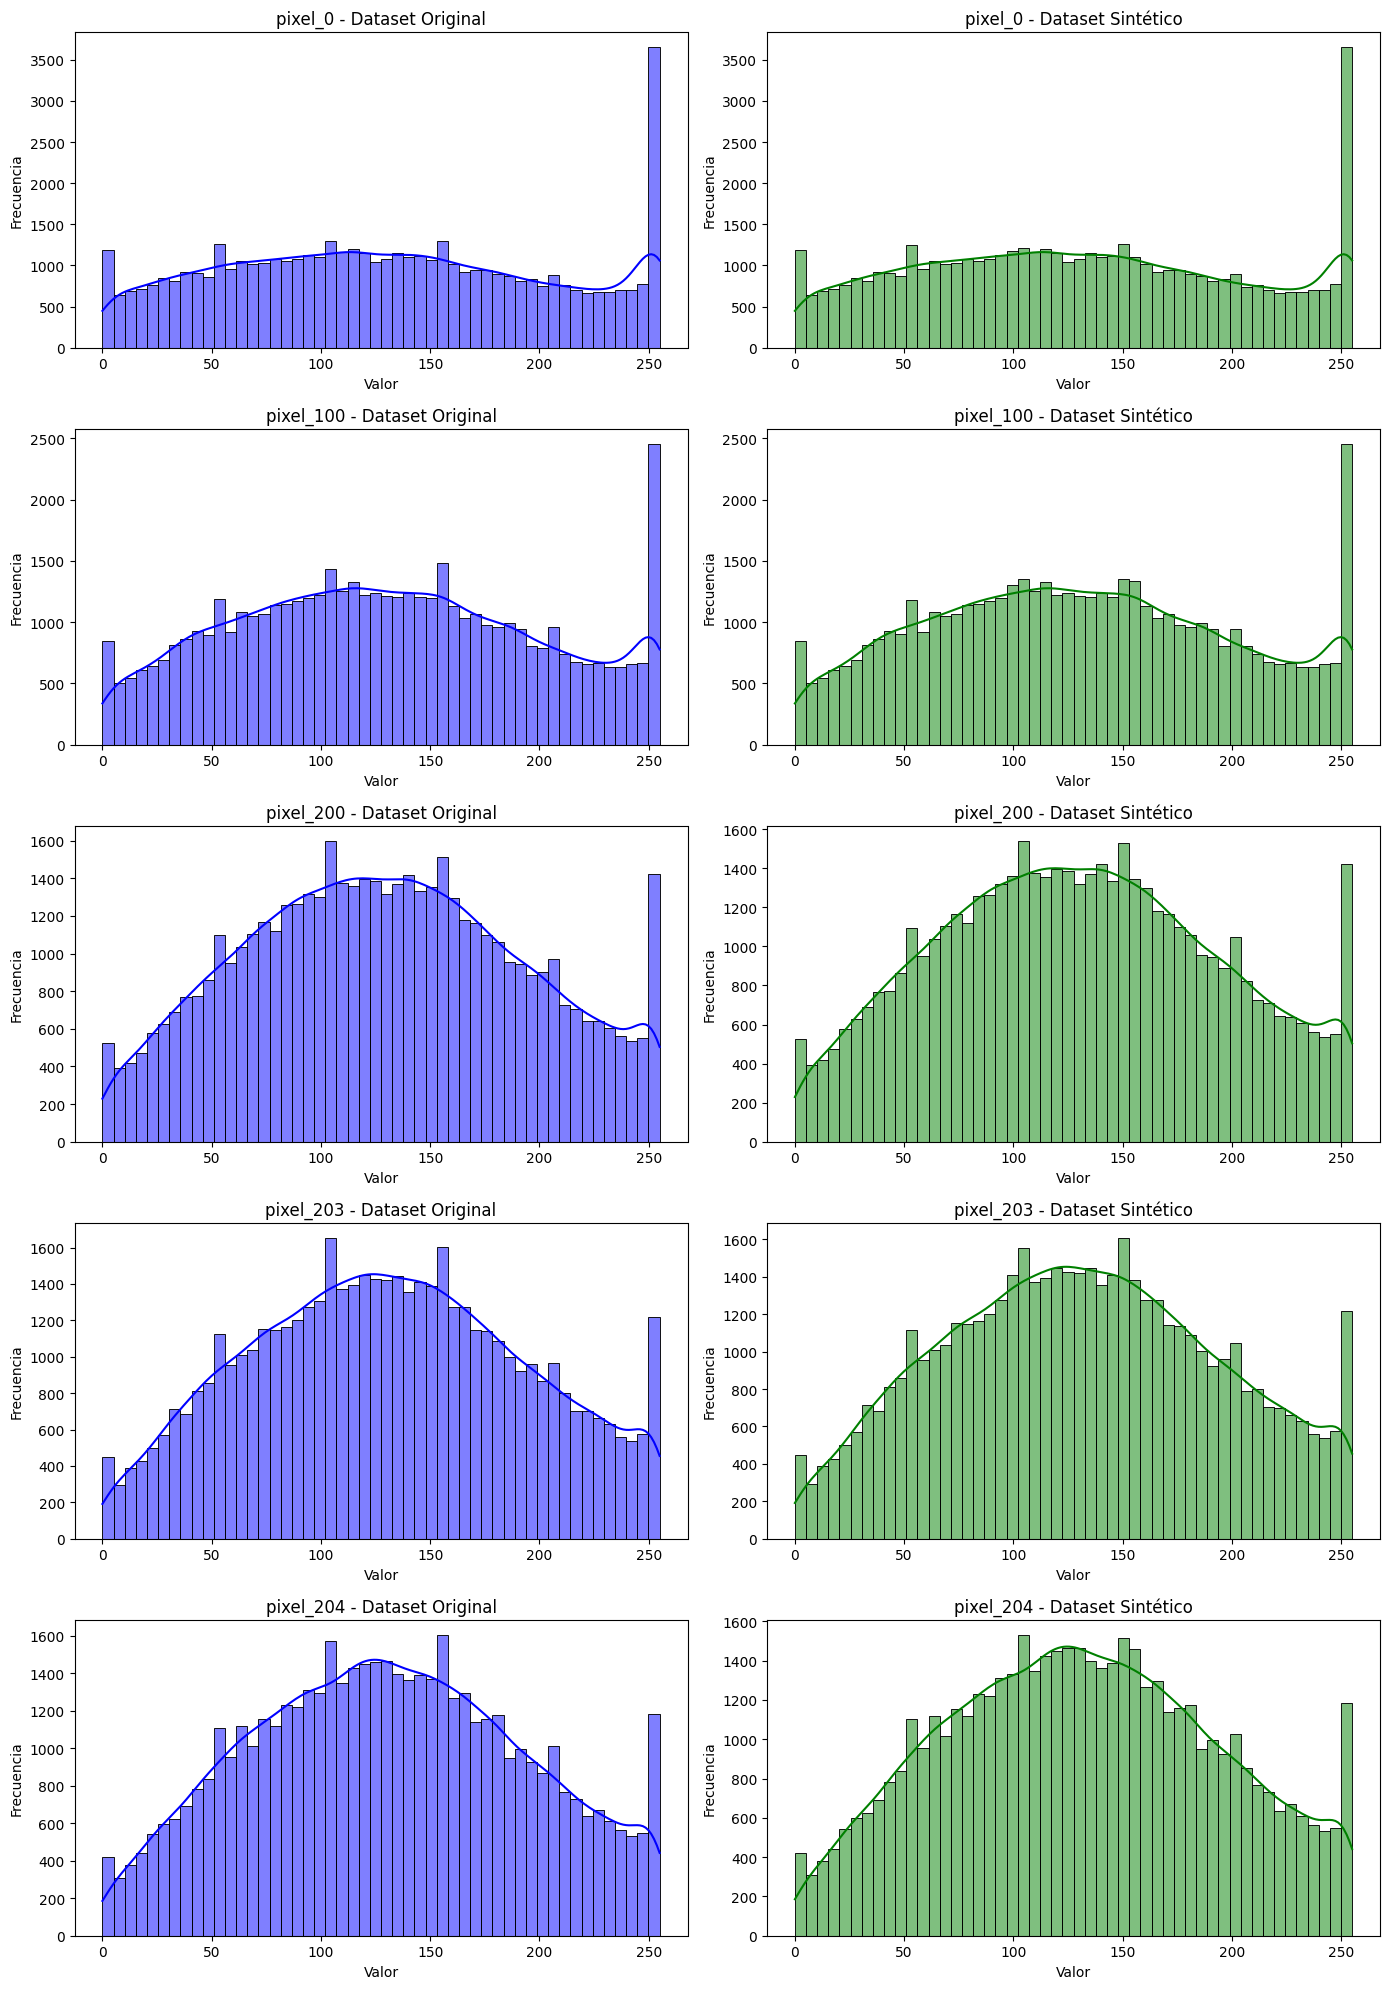

In [36]:
# Definir una muestra de características para visualizar
sample_features = ['pixel_0', 'pixel_100', 'pixel_200', 'pixel_203', 'pixel_204']  

# Crear una figura con dos subgráficos por característica
fig, axes = pyplot.subplots(nrows=len(sample_features), ncols=2, figsize=(14, len(sample_features) * 4))

# Graficar histogramas para cada característica en el dataset original y sintético
for i, feature in enumerate(sample_features):
    # Histograma para el dataset original
    sns.histplot(data[feature], bins=50, kde=True, ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f'{feature} - Dataset Original')
    axes[i, 0].set_xlabel('Valor')
    axes[i, 0].set_ylabel('Frecuencia')
    
    # Histograma para el dataset sintético
    sns.histplot(data_sintetico[feature], bins=50, kde=True, ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f'{feature} - Dataset Sintético')
    axes[i, 1].set_xlabel('Valor')
    axes[i, 1].set_ylabel('Frecuencia')

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


Gráficos de Dispersión: crea dos gráficos de dispersión que muestran la relación entre dos características específicas (pixel_0 y pixel_1) en dos conjuntos de datos diferentes: el dataset original y el dataset sintético. Esto permite comparar visualmente cómo se distribuyen las características seleccionadas en ambos conjuntos de datos y observar el efecto del ruido añadido en el dataset sintético.

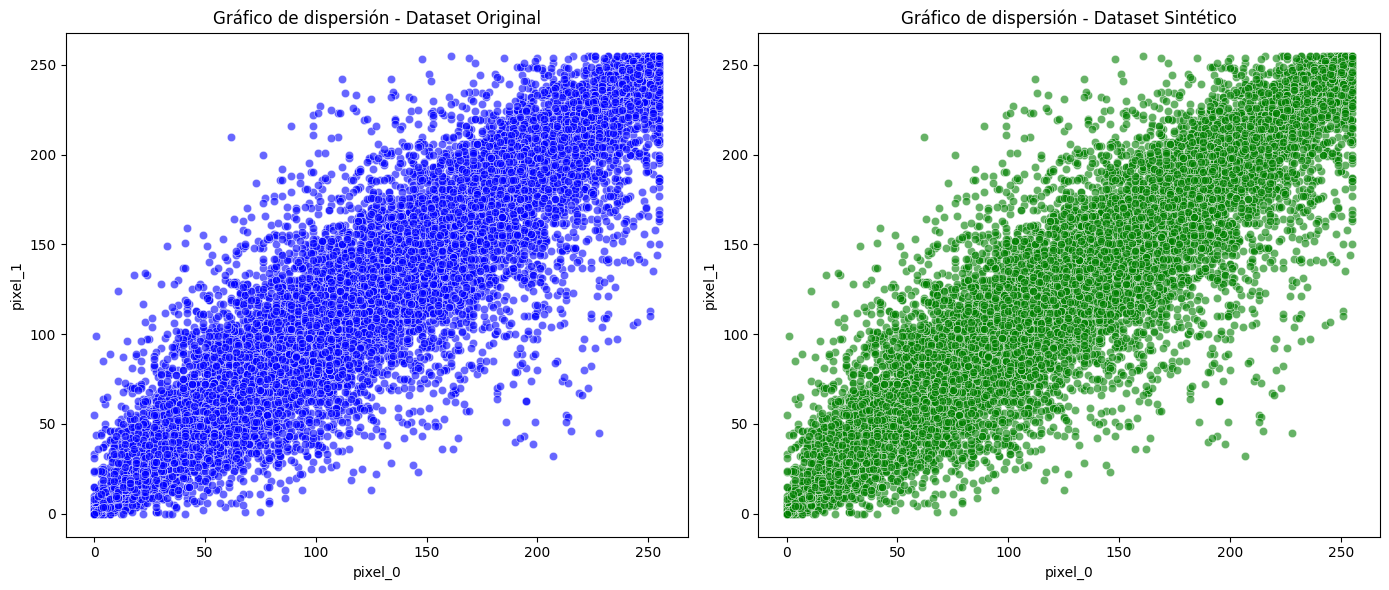

In [37]:
# Definir dos características para graficar
feature_x = 'pixel_0'
feature_y = 'pixel_1'

# Crear una figura con dos subgráficos
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfico de dispersión para el dataset original
sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Gráfico de dispersión - Dataset Original')
axes[0].set_xlabel(feature_x)
axes[0].set_ylabel(feature_y)

# Gráfico de dispersión para el dataset sintético
sns.scatterplot(x=data_sintetico[feature_x], y=data_sintetico[feature_y], ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Gráfico de dispersión - Dataset Sintético')
axes[1].set_xlabel(feature_x)
axes[1].set_ylabel(feature_y)

# Ajustar el espaciado entre los gráficos
pyplot.tight_layout()
pyplot.show()


### 3. Dividir los datos del dataset sintético en datos de entrenamiento y prueba
Dask es una biblioteca para el procesamiento de datos en paralelo y es útil para manejar datasets grandes que no caben en memoria.

In [4]:
# Leer el dataset usando Dask
df = dd.read_csv('dataset_sintetico.csv')

# Convertir el Dask DataFrame a Pandas DataFrame (esto será intensivo en memoria si el dataset es grande)
df_pandas = df.compute()

# Dividir en datos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
# usa la funcion de scikit-learn para dividir los datos
X_train, X_test = train_test_split(
    # Tiene el dataset, el tamaño de la prueba, la semilla y la estratificación
    df_pandas, test_size=0.2, random_state=42, stratify=df_pandas['label']
)

# Guardar los conjuntos de entrenamiento y prueba en archivos CSV
X_train.to_csv('sintetico_train.csv', index=False)
X_test.to_csv('sintetico_test.csv', index=False)

# Imprimir el tamaño de cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} ejemplos, {X_train.shape[1]} columnas")
print(f"Conjunto de prueba: {X_test.shape[0]} ejemplos, {X_test.shape[1]} columnas")

Conjunto de entrenamiento: 80000 ejemplos, 3076 columnas
Conjunto de prueba: 20000 ejemplos, 3076 columnas


### 4. modelo de regresión logística binaria 

Chunks se utilizan para manejar datos grandes de manera más eficiente. Cuando un archivo de datos es demasiado grande para ser cargado en la memoria RAM en su totalidad, puedes leerlo en fragmentos más pequeños (chunks) que se procesan uno por uno.

Este fracmento hace:

- Leer datos en chunks: Esto permite manejar grandes datasets sin cargar todo en memoria a la vez, lo que es útil para trabajar con datos que pueden ser demasiado grandes para la RAM disponible.

- Definir etiquetas de clase: Este diccionario se usa para traducir las etiquetas numéricas en nombres de clase significativos, facilitando la interpretación de los resultados del modelo.

In [2]:
# Leer el dataset completo
data_train = pd.read_csv('sintetico_train.csv')
data_test = pd.read_csv('sintetico_test.csv')


# Separar las características de píxeles (pixel00 a pixel3071) y la etiqueta (label)
train_X = data_train.iloc[:, :3072].values  # Selecciona las columnas de 'pixel00' a 'pixel3071'
train_y = data_train['label'].values        # Selecciona la columna 'label'

# separar las características y las etiquetas de dataset de prueba
test_X = data_test.iloc[:, :3072].values  # Selecciona las columnas de 'pixel00' a 'pixel3071'
test_y = data_test['label'].values        # Selecciona la columna 'label'

Aqui de saca la sigmoide(función de activación)

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$


In [20]:
# Función sigmoide
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [21]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    # sis es es 0 se cambia por 1
    sigma[sigma == 0] = 1  # verificar

    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

La funcion de costo(binary cross entropy) en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

- Gradiente: Ayuda a encontrar la dirección en la que la función de costo disminuye más rápidamente.
- Uso: Es utilizado por el algoritmo de optimización para ajustar los parámetros del modelo y minimizar el costo, mejorando así el rendimiento del modelo en los datos de entrenamiento.

In [22]:
# Función de coste con regularización
def calcularCosto(theta, X, y, lambda_):
    m = len(y)
    h = sigmoid(X @ theta)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    J = (-1 / m) * (np.dot(y, np.log(h)) + np.dot((1 - y), np.log(1 - h))) + reg_term

    grad = (1 / m) * X.T @ (h - y)
    grad[1:] += (lambda_ / m) * theta[1:]

    return J, grad

Funcion del decenso por el gradiente

El algoritmo de descenso por el gradiente es un método de optimización usado para minimizar una función de costo ajustando iterativamente los parámetros del modelo. En el código proporcionado, se aplica el descenso por el gradiente para encontrar los mejores valores para los parámetros del modelo en un problema de clasificación binaria

- (1 / m) * X.T.dot(h - y): Calcula el gradiente del costo con respecto a los parámetros. X.T.dot(h - y) mide la diferencia entre las predicciones y las etiquetas reales, multiplicado por las características X.
- (lambda_ / m) * np.concatenate([[0], theta[1:]]): Añade la regularización al gradiente. lambda_ / m es el término de regularización, y np.concatenate([[0], theta[1:]]) asegura que el término de sesgo theta[0] no se regularice.

In [23]:
# Gradiente descendente que guarda el coste y la precisión en cada epoch
def gradient_descent(X, y, theta, lambda_, alpha, num_iters):
    J_history = []
    accuracy_history = []
    
    for _ in range(num_iters):
        J, grad = calcularCosto(theta, X, y, lambda_)
        theta -= alpha * grad
        J_history.append(J)  # Guardar el costo en cada epoch
        
        # Calcular y guardar la precisión en el conjunto de entrenamiento
        predictions = sigmoid(X @ theta) >= 0.5
        accuracy = np.mean(predictions == y) * 100
        accuracy_history.append(accuracy)
    
    return theta, J_history, accuracy_history


inicializamos parametros y mostramos graficas de costos por clase

In [24]:
# Regresión logística binaria para cada clase
def binary_logistic_regression(X, y, num_labels, lambda_, alpha, num_iters):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))
    all_J_history = []  # Para guardar el historial de costo por clase
    all_accuracy_history = []  # Para guardar el historial de precisión por clase
    
    # Entrenamos un modelo de regresión logística binaria para cada clase
    for i in range(num_labels):
        initial_theta = np.zeros(n)
        y_i = (y == i+1).astype(int)  # Crear etiquetas binarias para la clase i
        theta, J_history, accuracy_history = gradient_descent(X, y_i, initial_theta, lambda_, alpha, num_iters)
        all_theta[i] = theta
        all_J_history.append(J_history)  # Guardar historial de costo
        all_accuracy_history.append(accuracy_history)  # Guardar historial de precisión
    
    return all_theta, all_J_history, all_accuracy_history

In [25]:
# Predicción
def predict_binary(all_theta, X):
    probabilities = sigmoid(X @ all_theta.T)
    return np.argmax(probabilities, axis=1) + 1  # Clase con la mayor probabilidad

In [26]:
# Normalizar las características
X_train_norm, mu, sigma = featureNormalize(train_X)

X_train = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])  # Añadir columna de unos


In [31]:
# Parámetros del modelo
num_labels = len(np.unique(train_y))  # Número de clases
lambda_ = 0.1
alpha = 0.001
num_iters = 50

In [32]:
# Realizar el entrenamiento y obtener el historial de costo y precisión
all_theta, all_J_history, all_accuracy_history = binary_logistic_regression(X_train, train_y, num_labels, lambda_, alpha, int(num_iters))  # Usa X_train

# Predicciones en el conjunto de entrenamiento
train_pred = predict_binary(all_theta, X_train)

# Calcular la precisión en el conjunto de entrenamiento
train_accuracy = np.mean(train_pred == train_y) * 100
print(f'Precisión en conjunto de entrenamiento: {train_accuracy:.2f}%')

Precisión en conjunto de entrenamiento: 31.76%


In [33]:
# Seleccionar las primeras 10 muestras de los datos de prueba
X_test_20 = test_X[:10]

# Añadir la columna de unos a las muestras de prueba
X_test_20 = np.hstack([np.ones((X_test_20.shape[0], 1)), X_test_20])

# Hacer predicciones sobre esas 20 muestras
test_pred_20 = predict_binary(all_theta, X_test_20)

# Mostrar las 20 predicciones
print("Predicciones para las primeras 20 muestras del conjunto de prueba:")
print(test_pred_20)

# Seleccionar las primeras 20 etiquetas reales
test_y_20 = test_y[:10]

# Calcular el porcentaje de acierto
accuracy_20 = np.mean(test_pred_20 == test_y_20) * 100

# Mostrar el porcentaje de acierto
print(f'Porcentaje de acierto en las primeras 20 predicciones: {accuracy_20:.2f}%')

# Contar cuántas predicciones acertaron
aciertos_20 = np.sum(test_pred_20 == test_y_20)

# Mostrar el número de aciertos
print(f'Número de predicciones acertadas en las primeras 20 muestras: {aciertos_20}')
# Visualización del costo y la precisión

Predicciones para las primeras 20 muestras del conjunto de prueba:
[5 5 5 8 5 8 8 8 8 8]
Porcentaje de acierto en las primeras 20 predicciones: 50.00%
Número de predicciones acertadas en las primeras 20 muestras: 5


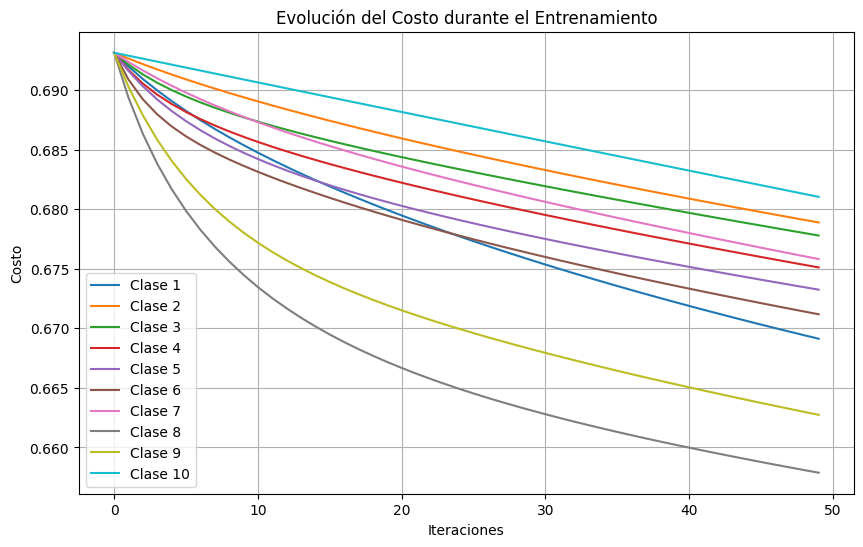

In [34]:
# Obtener el número de clases
num_labels = len(all_J_history)

# Crear una figura
pyplot.figure(figsize=(10, 6))

# Graficar el costo para cada clase
for i in range(num_labels):
    pyplot.plot(all_J_history[i], label=f'Clase {i+1}')

# Añadir títulos y etiquetas
pyplot.title('Evolución del Costo durante el Entrenamiento')
pyplot.xlabel('Iteraciones')
pyplot.ylabel('Costo')
pyplot.legend()
pyplot.grid(True)

# Mostrar la gráfica
pyplot.show()

### 5. Entrenamiento con modelo One-vs-All

In [74]:
# Ingresar imágenes de dígitos de 20x20
input_layer_size  = 3072

# 10 etiquetas, de 1 a 10 (tomar en cuenta que se asigna "0" a la etiqueta 10)
num_labels = 10

# Leer el archivo CSV usando pandas
df_train = pd.read_csv('sintetico_train.csv')
df_test = pd.read_csv('sintetico_test.csv')

# Separar las características de píxeles (pixel00 a pixel3071) y la etiqueta (label)
train_X = data_train.iloc[:, :3072].values  # Selecciona las columnas de 'pixel00' a 'pixel3071'
train_y = data_train['label'].values        # Selecciona la columna 'label'

# separar las características y las etiquetas de dataset de prueba
test_X = data_test.iloc[:, :3072].values  # Selecciona las columnas de 'pixel00' a 'pixel3071'
test_y = data_test['label'].values        # Selecciona la columna 'label'

m = len(train_y)

In [75]:
def displayData(X_pixels, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    # Calcula filas, columnas
    if X_pixels.ndim == 2:
        m, n = X_pixels.shape
    elif X_pixels.ndim == 1:
        n = X_pixels.size
        m = 1
        X_pixels = X_pixels[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensinal.')

    # Ancho de cada imagen
    example_width = example_width or int(np.round(np.sqrt(n // 3)))
    example_height = int(n / (example_width * 3))  # Para imágenes RGB (3 canales)

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Redimensionar cada imagen para mostrarla en formato 32x32 píxeles con 3 canales de color
        img = X_pixels[i].reshape(example_height, example_width, 3, order='F')
        ax.imshow(img.astype(np.uint8), extent=[0, 1, 0, 1])
        ax.axis('off')

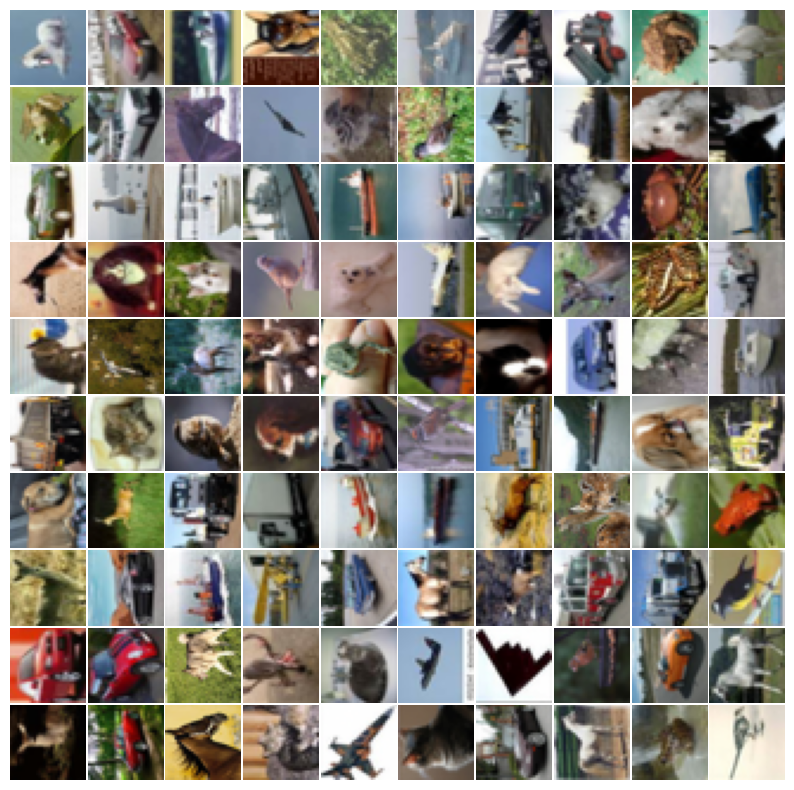

In [76]:
# Selecciona aleatoriamente 100 puntos de datos para mostrar
rand_indices = np.random.choice(m, 100, replace=False)
sel = train_X[rand_indices, :]

displayData(sel)

Formula de la normalización:

$$
X_{\text{norm}} = \frac{X - \mu}{\sigma}
$$

- X norm: es la versión normalizada de los datos X,
- 𝜇 : μ es la media de X,
- 𝜎 : σ es la desviación estándar de 𝑋.

In [77]:
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1  # Evitar división por cero
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_train_norm, mu, sigma = feature_normalize(train_X)
X_test_norm = (test_X - mu) / sigma
X_train = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])
X_test = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])

Aqui de saca la sigmoide(función de activación)

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$


In [85]:
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Limitar los valores de z para evitar desbordamientos
    return 1.0 / (1.0 + np.exp(-z))

Aqui de saca la función de costo:
$$
J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right)\right) - \left(1 - y^{(i)}\right) \log\left( 1 - h_\theta\left( x^{(i)} \right)\right) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2
$$

- La fórmula de la función de costo J(θ) se utiliza para medir la precisión del modelo de clasificación.
- El primer término de la suma mide el error entre las predicciones (hₓ(θ)) y los valores reales (y).
- hₓ(θ) es la hipótesis o predicción del modelo calculada usando la función sigmoide.
- El segundo término es el componente de regularización, que agrega λ para penalizar valores altos de los parámetros θ, ayudando a evitar el sobreajuste.
- La regularización no afecta al término de sesgo θ₀.


In [90]:
def cost_function(theta, X, y, lambda_):
    m = len(y)
    h = sigmoid(X @ theta)
    
    # Para evitar log(0), usamos un pequeño valor epsilon
    epsilon = 1e-5
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    
    J = (-1 / m) * (np.dot(y, np.log(h + epsilon)) + np.dot((1 - y), np.log(1 - h + epsilon))) + reg_term

    # Gradiente
    grad = (1 / m) * X.T @ (h - y)
    grad[1:] += (lambda_ / m) * theta[1:]

    return J, grad

In [91]:
def gradient_descent(X, y, theta, lambda_, alpha, num_iters):
    J_history = []

    for _ in range(num_iters):
        J, grad = cost_function(theta, X, y, lambda_)
        theta = theta - alpha * grad
        J_history.append(J)

    return theta, J_history


In [38]:
def one_vs_all(X, y, num_labels, lambda_, alpha, num_iters):
    n = X.shape[1]
    all_theta = np.zeros((num_labels, n))
    all_J_history = []  # Lista para almacenar los historiales de costos

    for i in range(num_labels):
        initial_theta = np.zeros(n)
        y_i = (y == i + 1).astype(int)
        theta, J_history = gradient_descent(X, y_i, initial_theta, lambda_, alpha, num_iters)
        all_theta[i] = theta
        all_J_history.append(J_history)  # Guardar el historial de costos para esta clase

    return all_theta, all_J_history  # Retorna all_J_history en lugar de J_history

In [93]:
# Función para predecir
def predict_one_vs_all(all_theta, X):
    return np.argmax(sigmoid(X @ all_theta.T), axis=1) + 1

In [99]:
# Normaliza el conjunto de entrenamiento
X_train_norm, mu, sigma = featureNormalize(train_X)
# Añadir columna de unos al conjunto de entrenamiento
X_train = np.hstack([np.ones((X_train_norm.shape[0], 1)), X_train_norm])

# Normaliza el conjunto de prueba usando los mismos mu y sigma
# Nota: `mu` y `sigma` tienen dimensiones que no incluyen la columna de unos
X_test_norm = (test_X - mu) / sigma
# Añadir columna de unos al conjunto de prueba después de la normalización
X_test = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])

# Parámetros para el entrenamiento
num_labels = len(np.unique(train_y))
lambda_ = 0.1
alpha = 0.01
num_iters = 10
all_theta, all_J_history = one_vs_all(X_train, train_y, num_labels, lambda_, alpha, num_iters)

# Calcular el costo en el conjunto de entrenamiento para la clase 1
J_train, _ = cost_function(all_theta[0], X_train, (train_y == 1).astype(int), lambda_)
print(f'Costo en el conjunto de entrenamiento para la clase 1: {J_train:.4f}')

# Calcular el costo en el conjunto de prueba para la clase 1
J_test, _ = cost_function(all_theta[0], X_test, (test_y == 1).astype(int), lambda_)
print(f'Costo en el conjunto de prueba para la clase 1: {J_test:.4f}')


Costo en el conjunto de entrenamiento para la clase 1: 0.6570
Costo en el conjunto de prueba para la clase 1: 0.6577


### 6. Verificar efectividad con dataset de prueba

In [103]:
# Calcular la precisión en el conjunto de entrenamiento
train_pred = predict_one_vs_all(all_theta, X_train)
train_accuracy = np.mean(train_pred == train_y) * 100
print(f'Precisión en conjunto de entrenamiento: {train_accuracy:.2f}%')

# Calcular la precisión en el conjunto de prueba
test_pred = predict_one_vs_all(all_theta, X_test)
test_accuracy = np.mean(test_pred == test_y) * 100
print(f'Precisión en conjunto de prueba: {test_accuracy:.2f}%')


Precisión en conjunto de entrenamiento: 32.28%
Precisión en conjunto de prueba: 31.98%


In [104]:
# Seleccionar las primeras 20 muestras de los datos de prueba
X_test_20 = X_test[:20]

# Hacer predicciones sobre esas 20 muestras
test_pred_20 = predict_one_vs_all(all_theta, X_test_20)

# Mostrar las 20 predicciones
print("Predicciones para las primeras 20 muestras del conjunto de prueba:")
print(test_pred_20)
# Seleccionar las primeras 10 etiquetas reales
test_y_20 = test_y[:20]

# Calcular el porcentaje de acierto
accuracy_20 = np.mean(test_pred_20 == test_y_20) * 100

# Mostrar el porcentaje de acierto
print(f'Porcentaje de acierto en las primeras 20 predicciones: {accuracy_20:.2f}%')

# Contar cuántas predicciones acertaron
aciertos_20 = np.sum(test_pred_20 == test_y_20)

# Mostrar el número de aciertos
print(f'Número de predicciones acertadas en las primeras 20 muestras: {aciertos_20}')

Predicciones para las primeras 20 muestras del conjunto de prueba:
[3 5 6 8 5 8 4 9 8 8 8 8 8 7 9 4 9 6 3 7]
Porcentaje de acierto en las primeras 20 predicciones: 55.00%
Número de predicciones acertadas en las primeras 20 muestras: 11


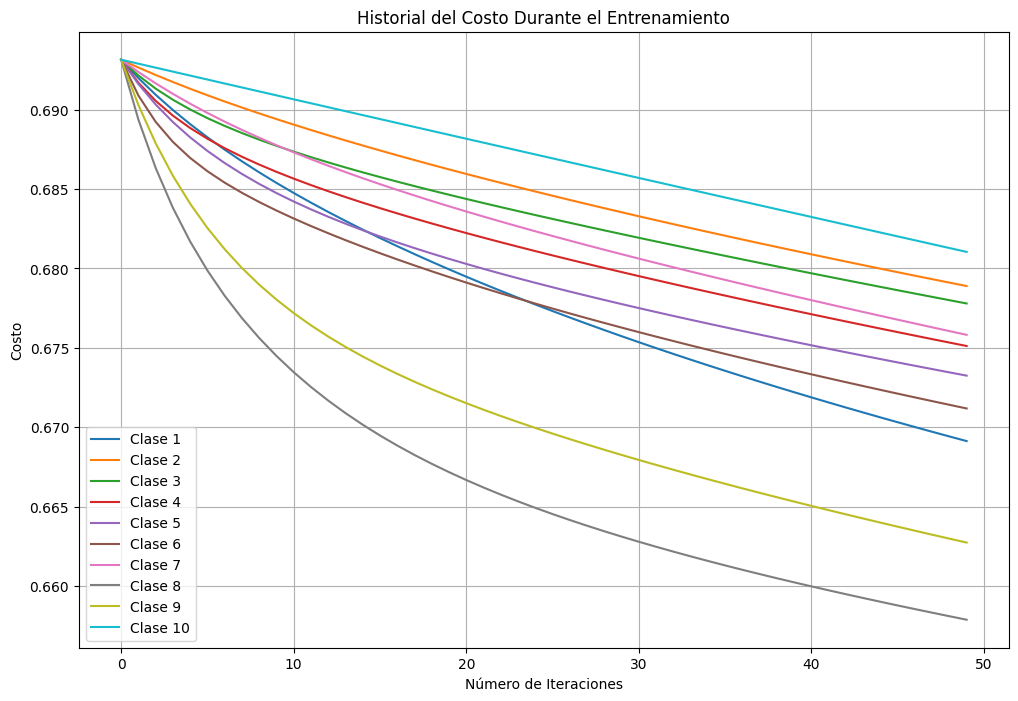

In [35]:
# Graficar el costo a lo largo de las iteraciones
def plot_cost_history(all_J_history):
    # El historial de costo tiene una lista de costos para cada clase
    num_classes = len(all_J_history)
    
    pyplot.figure(figsize=(12, 8))
    
    for i in range(num_classes):
        pyplot.plot(all_J_history[i], label=f'Clase {i+1}')
    
    pyplot.xlabel('Número de Iteraciones')
    pyplot.ylabel('Costo')
    pyplot.title('Historial del Costo Durante el Entrenamiento')
    pyplot.legend()
    pyplot.grid(True)
    pyplot.show()

# Supongamos que 'all_J_history' es una lista donde cada elemento es el historial de costos para una clase
plot_cost_history(all_J_history)